# Visualize I and O tensors

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
# from torchvision.utils import make_grid
import pandas as pd

from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as grd
%matplotlib inline



matplotlib.rcParams['figure.figsize'] = (12,4)
# matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Logging ML
from torch.utils.tensorboard import SummaryWriter
import wandb

In [2]:
config = dict(    
    learning_rate =1e-3,
    # batch_size =128,
    epochs = int(3e3),
    model="nn3",
    layers = [256,128,128,64],
    training_loss = "MSE+tP",
    alpha= 1e-6,
    # scheduler = "one-cycle-lr",
    years=["2011","2013","2014"],
    years_val=["2012"],
    nodes="37"
)
use_tb = False
use_wandb= True
manual_logging = False
check_data_with_plots = False

project_name = f"phd-ph5x-02-power_prediction_{config['nodes']}"

random_seed = 746435
torch.manual_seed(random_seed)

In [3]:
dir_root = Path("../") # go to root of git repo
dir_data = dir_root / "data"
dir_data_ml= dir_data /"ml"
dir_models = dir_root / "models"
dir_runs = dir_root/"runs"
dir_runs_tb = dir_runs /"tb"
dir_runs_wandb = dir_root / "wandb"
param_save = "002_01_simplest"

network_name = f"elec_s_{config['nodes']}_ec_lcopt_Co2L-3H"

dir_training_set = [dir_data_ml / y / "3M" for y in config["years"]]
filenames_inputs_tr = [d / f"{network_name}_inputs.P" for d in dir_training_set]
filenames_outputs_tr = [d / f"{network_name}_outputs_p.P" for d in dir_training_set]

dir_val_set = [ dir_data_ml / y/ "3M" for y in  config["years_val"]]
filenames_inputs_val = [d / f"{network_name}_inputs.P" for d in dir_val_set]
filenames_outputs_val = [d / f"{network_name}_outputs_p.P" for d in dir_val_set]

for fn in [*filenames_inputs_tr, *filenames_outputs_tr,
           *filenames_inputs_val,*filenames_outputs_val]:
    if not fn.exists():
        print(f"{fn}: Missing")
print("Otherwise all files present")

Otherwise all files present


### Load data

In [19]:
def read_all_dfs(filenames):
    return pd.concat([pd.read_pickle(f) for f in filenames])

df_input_tr = read_all_dfs(filenames_inputs_tr)
df_output_tr = read_all_dfs(filenames_outputs_tr)
df_input_val = read_all_dfs(filenames_inputs_val)
df_output_val = read_all_dfs(filenames_outputs_val)


assert (df_input_val.columns==df_input_tr.columns).all(), "Mismatch in input columns"
assert (df_output_val.columns==df_output_tr.columns).all(), "Mismatch in output columns"
input_features = df_input_val.columns
output_features = df_output_val.columns

x_train = torch.from_numpy(df_input_tr.values.astype("float32"))
y_train = torch.from_numpy(df_output_tr.values.astype("float32"))
x_val = torch.from_numpy(df_input_val.values.astype("float32"))
y_val = torch.from_numpy(df_output_val.values.astype("float32"))

n_input = x_train.shape[1]
n_output = y_train.shape[1]
n_samples_tr = x_train.shape[0]
n_samples_val = x_val.shape[0]

# Normalization defined by training data
x_mean = x_train.mean(dim = 0)
x_std =x_train.std(dim = 0)
y_mean = torch.zeros(n_output)  # centered already
y_std = y_train.std(dim = 0)

def x_norm(x): return (x-x_mean)/x_std
def y_norm(y): return (y-y_mean)/y_std
def x_renorm(x): return x*x_std+x_mean
def y_renorm(y): return y*y_std+y_mean


x_train =  x_norm(x_train)
y_train = y_norm(y_train)

x_val = x_norm(x_val)
y_val = y_norm(y_val)
assert not(((x_val[0:100]-x_train[0:100])<1e-5).all()), "Training data identical to validation data"


(n_input,n_output,n_samples_tr,n_samples_val)
# train_loader = load

(219, 37, 8760, 2928)

In [49]:
## All outputs


filenames_outputs_all = [d / f"{network_name}_outputs.P" for d in dir_training_set]
df_output_all = read_all_dfs(filenames_outputs_all)
y_all = torch.from_numpy(df_output_all.values.astype("float32"))

# Normalization defined by training data

y_all_mean = y_all.mean(dim = 0)  # centered already
y_all_std = y_all.std(dim = 0)

def y_all_norm(y): return (y-y_all_mean)/y_all_std
def y_all_renorm(y): return y*y_all_std+y_all_mean

y_all = y_all_norm(y_all)


In [5]:
# Sort generator technologies
col= df_input_tr.columns
sorted_gen =col[col.str.startswith("generators")].str.split(" ").str[3].argsort()
ngen =col.str.startswith("gen").sum()
index_sorted_technologies = np.concatenate([sorted_gen,list(range(ngen,len(col)))])

In [138]:
## Sorting output generators based on type
gen_sorted_index =df_output_all.iloc[:,df_output_all.columns.str.startswith("gen")].columns.str.split(" ").str[-1].argsort()

nG1=df_output_all.columns.str.startswith("gen").argmax()
nG2 = nG1+df_output_all.columns.str.startswith("gen").sum()

df_output_all.columns[[nG1-1,nG1,nG1+1,nG2-1,nG2,nG2+1]]
output_all_sorted_index = np.concatenate([
            list(range(0,nG1)),
           gen_sorted_index+nG1,
           list(range(nG2,df_output_all.shape[1]))])

In [6]:
index_sorted_technologies 

array([  0,  94,  47,  89,  84,  25,  76,  98,  71,  66,  61,  34,  56,
        38,  51,  30, 106,  42, 111,  14, 117, 148, 121,   9, 126, 143,
       131, 135,  99,  48, 144,  52,  57, 136, 127, 107,  67,  72, 122,
        85, 118,  62,  90,  77,  26,  10,  31,  39,  15,  35,  43,  81,
       140,  86,  22, 137,  91,   4,  95,  19,  44,  78,  16, 108, 132,
       112, 115, 119, 128,  11, 123, 100, 103,   7,   1,  32,  63,  58,
       145,  36,  68,  53,  73, 149,  40,  27,  49, 152,  54, 109,  59,
       113,  17, 133, 104, 150, 101,  74,  96,   5,  45, 153,  28,  79,
       141,  82,  69, 124,  23,  87, 138,   2,  64,  92,  20, 129, 146,
        12, 151, 147,   6, 134,   3, 142, 130, 139,  18, 125,  46,  41,
        50,  37,  55,  60,  33,  65,  29,  70,  75,  80,  83,  24,  88,
        21,  93,  97, 102, 105, 110, 114, 116,  13, 120,   8, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [265]:
def heat_map_labeled(  df, ax= None, tech_labels=None, cmap="magma",label=None,ticklabels_kwargs=dict(),**kwargs ):
    a= tech_labels.value_counts(sort=False).values
    y_ticks_major = a.cumsum()-1
    y_ticks_minor = y_ticks_major - a/2

    y_labels_major= tech_labels.unique()
    y_labels_major = [ f"{x} ⇥"  for x in y_labels_major] #⇥

# fig,ax = plt.subplots(1,2,gridspec_kw=dict(width_ratios=[9,1]),figsize=(10,9),sharey='all')
    ax.imshow(df.T, cmap=cmap, aspect='auto',**kwargs)
    ax.xaxis.tick_top()
    ax.set_yticks(y_ticks_minor, minor=True)
    ax.set_yticklabels(a, minor=True,size=8)

    ax.set_yticks(y_ticks_major, minor=False)
    ax.set_yticklabels(y_labels_major, minor=False,rotation=-20,verticalalignment="bottom",transform=matplotlib.transforms.Affine2D().skew_deg(-100,0))
    # for l in ax.get_yticklabels():
    #     l.set_verticalalignment('bottom')
    ax.set_ylabel(label,fontsize=18)
    ax.tick_params('y', length=5, width=2, which='major')
    ax.tick_params('y', length=0, width=0, which='minor')


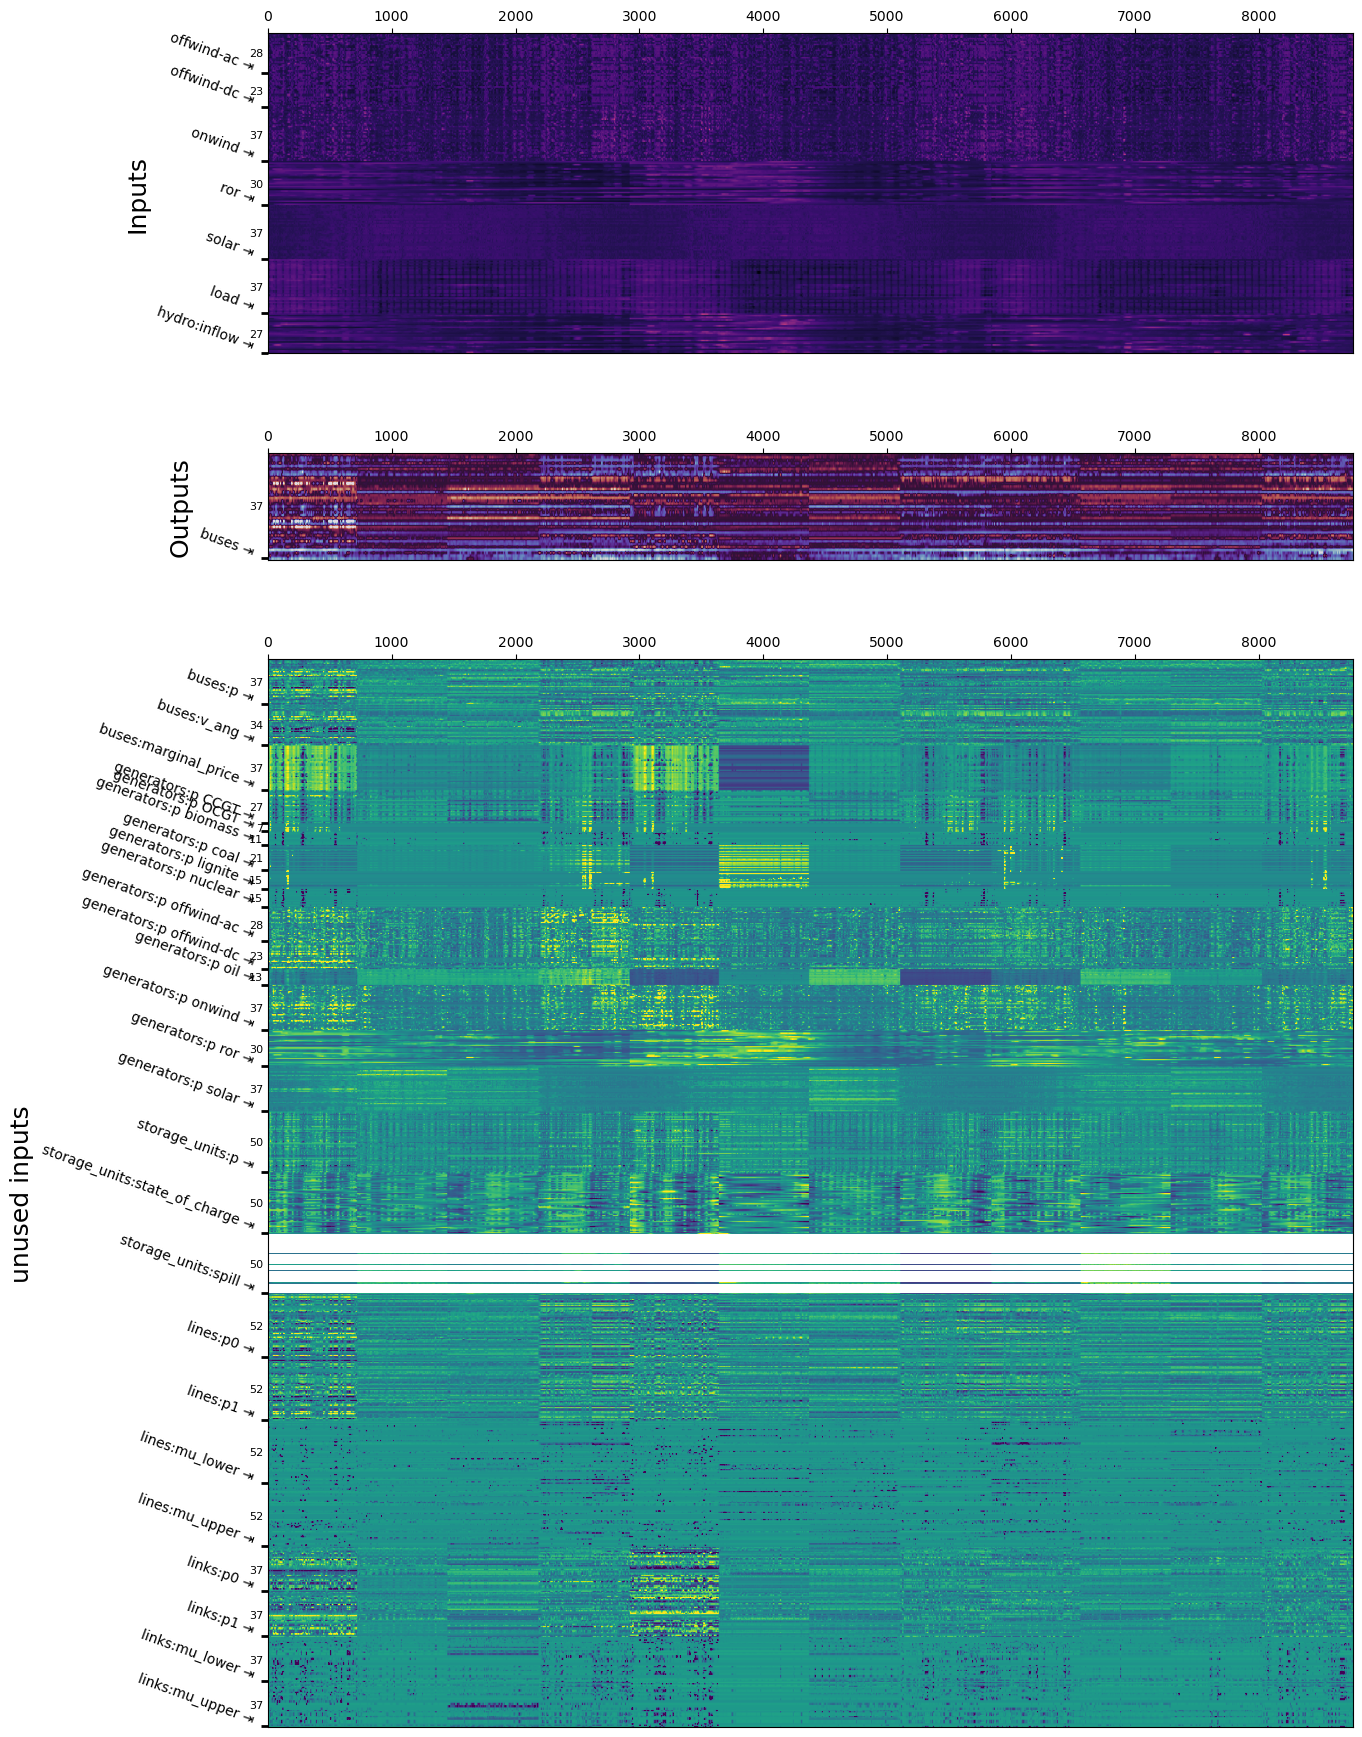

In [269]:



fig = plt.figure(figsize=(14,22))
# create a 3x1 grid 
gs = grd.GridSpec(3, 1, height_ratios=[3,1,10])#, wspace=0.1)

# image plot
ax = [plt.subplot(g) for g in gs]








df_x=pd.DataFrame(x_train,columns=df_input_tr.columns,index=df_input_tr.index
                  ).iloc[:,df_input_tr.columns.argsort()].iloc[:,index_sorted_technologies]
input_tech =  (df_x.columns.str.split(" ").str[-1]).to_series().replace({'0':'load',"hydro":"hydro:inflow"})

df_y=pd.DataFrame(y_train,columns=df_output_tr.columns,index=df_output_tr.index)
output_tech =  (df_y.columns.str.split(":").str[0]).to_series()

df_yall=pd.DataFrame(y_all,columns=df_output_all.columns,index=df_output_all.index
                     ).iloc[:,output_all_sorted_index]

output_tech_yall =  (   df_yall.columns.str.split(":").str[0:2].str.join(":")).to_series().reset_index(drop=True
                    ).str.cat(
                        df_yall.columns.str.extract(r"^gen\S*\s\S*\s\S*(\s.*)$")[0],
                    na_rep="")

ax[0]= heat_map_labeled(df_x, ax[0], input_tech,label="Inputs",cmap="magma")
ax[1]= heat_map_labeled(df_y, ax[1], output_tech,label="Outputs",cmap="twilight",vmin=-4,vmax=4)

ax[2]= heat_map_labeled(df_yall, ax[2],output_tech_yall,label="unused inputs",cmap="viridis",vmin=-3,vmax=3)
# fig.savefig("fn.png")


In [146]:
(df_yall.columns.str.split(":").str[0:2].str.join(":")).to_series()

buses:p                  buses:p
buses:p                  buses:p
buses:p                  buses:p
buses:p                  buses:p
buses:p                  buses:p
                       ...      
links:mu_upper    links:mu_upper
links:mu_upper    links:mu_upper
links:mu_upper    links:mu_upper
links:mu_upper    links:mu_upper
links:mu_upper    links:mu_upper
Length: 878, dtype: object

In [232]:
xxx=(df_yall.columns.str.split(":").str[0:2].str.join(":")).to_series().reset_index(drop=True)
yyy=df_yall.columns.str.extract(r"^gen\S*\s\S*\s\S*(\s.*)$")[0]
xxx.str.cat(yyy,na_rep="")

# yyy[0]
# [(type(x),x.dtype,len(x) )for x in(xxx,yyy)]
# print(yyy.iloc[103:110])

array(['buses:p', 'buses:v_ang', 'buses:marginal_price',
       'generators:p CCGT', 'generators:p OCGT', 'generators:p biomass',
       'generators:p coal', 'generators:p lignite',
       'generators:p nuclear', 'generators:p offwind-ac',
       'generators:p offwind-dc', 'generators:p oil',
       'generators:p onwind', 'generators:p ror', 'generators:p solar',
       'storage_units:p', 'storage_units:state_of_charge',
       'storage_units:spill', 'lines:p0', 'lines:p1', 'lines:mu_lower',
       'lines:mu_upper', 'links:p0', 'links:p1', 'links:mu_lower',
       'links:mu_upper'], dtype=object)

In [9]:
if check_data_with_plots:
    n_min=min(n_samples_val,n_samples_tr)
    _=plt.plot(x_train[:n_min], "r", alpha = 0.1) # [:,38:192]
    _=plt.plot(y_train[:n_min], "b", alpha = 0.1) # [:,38:192]
    _=plt.plot(x_val[:n_min], "m", alpha = 0.1) # [:,38:192]
    _=plt.plot(y_val[:n_min], "c", alpha = 0.1) # [:,38:192]
